In [1]:
import numpy as np
import cvxpy as cp
import networkx as nx

from numpy.random import default_rng
from opt_utils import decompose_psd, hyperplane_rounding, complex_hyperplane_rounding, fixed_point_iteration, normalize_rows, load_graph

# Max-cut

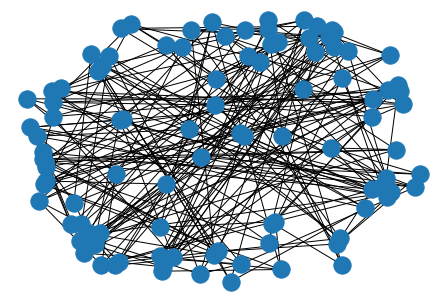

In [2]:
# graph_file = "torusg3-8.dat"
graph_file = "toruspm3-8-50.dat"

n = 100
G = load_graph(graph_file, n)

In [3]:
L = nx.laplacian_matrix(G).toarray() * 1.0

In [4]:
X = cp.Variable((n,n), PSD=True)
constraints = [ X[i][i] == 1 for i in range(n) ]
prob = cp.Problem(cp.Maximize(1/4 * (cp.trace(L @ X))), constraints)
prob.solve()

87.45659419732071

In [5]:
hyperplane_rounding(decompose_psd(X.value), lambda Y : -1/4 * np.trace(Y @ Y.T @ L))

(-77.0,
 array([[-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
  

In [6]:
fixed_point_iteration(prob, X, np.zeros((n,n)), False)

Initial objective:  87.45659419732071
Initial rank:  13
Current objective:  82.43531485380518
Current rank:  3
Current objective:  72.99999960506072
Current rank:  96
Fixed point objective:  73.00000000000009
Fixed point rank:  1
Fixed point eigenvalues:
[-2.63369469e-14 -1.94933246e-14 -1.87197009e-14 -1.85597171e-14
 -1.80704922e-14 -1.80282623e-14 -1.76957724e-14 -1.75640776e-14
 -1.74220164e-14 -1.72634018e-14 -1.71839648e-14 -1.71371635e-14
 -1.69800789e-14 -1.67435776e-14 -1.65955955e-14 -1.65689780e-14
 -1.63760871e-14 -1.63516439e-14 -1.61950283e-14 -1.61753510e-14
 -1.60343808e-14 -1.59429748e-14 -1.59125252e-14 -1.57851087e-14
 -1.56879161e-14 -1.56667042e-14 -1.55574860e-14 -1.55073756e-14
 -1.54287755e-14 -1.53514436e-14 -1.52846793e-14 -1.51156311e-14
 -1.50893466e-14 -1.50132826e-14 -1.49158598e-14 -1.48343514e-14
 -1.47607079e-14 -1.47274450e-14 -1.46705357e-14 -1.45991954e-14
 -1.45243936e-14 -1.44369698e-14 -1.44043786e-14 -1.43559599e-14
 -1.42791657e-14 -1.41702297e-

# PhaseCut (maximize)

In [7]:
n = 50  # number of observations
p = 20  # dimension of x
max_val = 10

In [8]:
rng = default_rng()
A = rng.random((n,p)) * max_val + rng.random((n,p)) * max_val * 1j
assert np.linalg.matrix_rank(A, tol=1e-9) >= p  # A must be injective; if the rows of A are linearly independent, AA+ = I
b = rng.random(n) * max_val
M = np.diag(b) @ (np.identity(n) - A @ np.linalg.pinv(A)) @ np.diag(b)

In [9]:
U = cp.Variable((n,n), hermitian=True)

### Unit modulus

In [10]:
constraints = [U >> 0]
constraints += [U[i][i] == 1 for i in range(n)]

prob = cp.Problem(cp.Maximize(cp.real(cp.trace(M @ U))), constraints)
prob.solve()

1547.465323260704

In [11]:
complex_hyperplane_rounding(decompose_psd(U.value), lambda u : -np.real(u.conj().T @ M @ u))

(array([[-1495.35111645]]),
 array([[-0.6810276 -0.73225775j],
        [ 0.61887864+0.78548662j],
        [-0.99528919+0.0969507j ],
        [ 0.20258976+0.9792637j ],
        [-0.67498426+0.73783212j],
        [-0.66490901-0.74692437j],
        [ 0.10536292-0.99443384j],
        [-0.75617944-0.65436431j],
        [-0.97594732+0.2180065j ],
        [-0.57669706+0.81695808j],
        [-0.99139295+0.13091988j],
        [-0.66040699-0.75090786j],
        [-0.83796809+0.54571923j],
        [-0.98877141+0.14943593j],
        [-0.4978507 +0.86726275j],
        [-0.6288168 -0.77755349j],
        [ 0.09855042-0.99513206j],
        [ 0.89969175-0.43652579j],
        [ 0.00235972+0.99999722j],
        [ 0.20608794-0.97853347j],
        [ 0.61274929-0.79027736j],
        [-0.9124554 +0.40917618j],
        [-0.66128034+0.75013886j],
        [ 0.43712937+0.89939864j],
        [-0.88394726-0.46758661j],
        [ 0.09697807-0.99528652j],
        [ 0.70088369+0.71327558j],
        [-0.12589154-0.9920

In [12]:
fixed_point_iteration(prob, U, -np.zeros((n,n)), True)

Initial objective:  1547.465323260704
Initial rank:  31
Current objective:  1476.1826204034744
Current rank:  9
Fixed point objective:  1476.182621561767
Fixed point rank:  1
Fixed point eigenvalues:
[-1.81642323e-14 -5.55188797e-15 -5.34461784e-15 -5.17245219e-15
 -4.78169704e-15 -4.64245976e-15 -4.60667083e-15 -4.44610717e-15
 -4.29281175e-15 -4.20126970e-15 -4.15496258e-15 -4.05012629e-15
 -3.92165800e-15 -3.83421796e-15 -3.71056381e-15 -3.65219135e-15
 -3.50682798e-15 -3.43885624e-15 -3.38543316e-15 -3.30719106e-15
 -3.24847461e-15 -3.17110794e-15 -3.04772181e-15 -2.99923603e-15
 -2.90744689e-15 -2.86858313e-15 -2.70144625e-15 -2.63679841e-15
 -2.53965862e-15 -2.47719228e-15 -2.36886756e-15 -2.26475071e-15
 -2.20128760e-15 -2.13895125e-15 -2.07994193e-15 -2.04366021e-15
 -1.87296627e-15 -1.84989506e-15 -1.70931819e-15 -1.58001207e-15
 -1.47845398e-15 -1.39249320e-15 -1.26151801e-15 -1.13958099e-15
 -9.97834802e-16 -7.81969994e-16 -6.74171416e-16 -5.60219292e-16
  1.40839972e-14  5.

### Relaxed bounds

In [13]:
delta = 0.05

In [17]:
constraints = [U >> 0]
constraints += [cp.real(U[i][i]) >= 1 - delta for i in range(n)]
constraints += [cp.real(U[i][i]) <= 1 + delta  for i in range(n)]

prob = cp.Problem(cp.Maximize(cp.real(cp.trace(M @ U))), constraints)
prob.solve()

1624.8385895961233

In [15]:
complex_hyperplane_rounding(decompose_psd(U.value), lambda u : -np.real(u.conj().T @ M @ u), 1 - delta, 1 + delta)

(array([[-1560.34356035]]),
 array([[-0.45897384+0.83177101j],
        [ 1.04573266+0.09456852j],
        [-1.03745812+0.16180433j],
        [ 0.04055976-1.04921633j],
        [ 0.71199908-0.7717236j ],
        [ 0.09892985-0.94483485j],
        [ 0.29108921+1.00884442j],
        [-1.03315968-0.18729941j],
        [ 0.99511538+0.33503041j],
        [ 0.83081436+0.46070326j],
        [ 0.44058366+0.95309288j],
        [ 0.89635664+0.31471379j],
        [ 1.02516117+0.2270343j ],
        [-0.67238306-0.80647444j],
        [-1.04992659+0.01241596j],
        [ 0.94661281+0.08015107j],
        [-0.70708201+0.63445649j],
        [-0.94679366-0.07798573j],
        [ 0.81597425-0.66082224j],
        [ 0.62162623+0.71838766j],
        [-0.48451355+0.93152918j],
        [ 1.04824003+0.06076867j],
        [-0.9475446 -0.45239279j],
        [-0.91602579+0.25178713j],
        [ 0.28460969+1.01069151j],
        [ 1.04730558+0.07517333j],
        [-0.5503562 +0.85166648j],
        [-0.00880426+1.0499

In [18]:
# fixed_point_iteration(prob, U, np.zeros((n,n)), True)
fixed_point_iteration(prob, U, -np.eye(n), True)

Initial objective:  1624.8385895961233
Initial rank:  30
Current objective:  1550.6378660987828
Current rank:  4
Current objective:  1538.746869993063
Current rank:  1
Fixed point objective:  1538.746869987459
Fixed point rank:  1
Fixed point eigenvalues:
[1.24957224e-12 1.26343313e-12 1.26377600e-12 1.26394450e-12
 1.26420525e-12 1.26441134e-12 1.26453902e-12 1.26467369e-12
 1.26479316e-12 1.26498540e-12 1.26509065e-12 1.26523197e-12
 1.26533928e-12 1.26539478e-12 1.26552951e-12 1.26562532e-12
 1.26566407e-12 1.26570534e-12 1.26580630e-12 1.26588359e-12
 1.26604861e-12 1.26611464e-12 1.26626420e-12 1.26639804e-12
 1.26648045e-12 1.26656795e-12 1.26665262e-12 1.26673967e-12
 1.26683627e-12 1.26687565e-12 1.26699977e-12 1.26706450e-12
 1.26719615e-12 1.26727478e-12 1.26741896e-12 1.26747562e-12
 1.26762453e-12 1.26773775e-12 1.26784484e-12 1.26797883e-12
 1.26813400e-12 1.26826072e-12 1.26835775e-12 1.26855326e-12
 1.26861602e-12 1.26873886e-12 1.26907638e-12 1.26918285e-12
 1.28089923e